In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Introduction
This notebook will be modeling cancer detection over digital pathology samples.  

Overall, I will be 
* Performing exploratory data analysis (EDA)
* Cleaning and preparing data for processing
* Model Training and Tuning
* Results + Discussion
* Conclusion

# Exploratory Data Analysis
As this is the first project using image data, I'll be processing this data a bit differently than a standard text-based project.  

Starting off, let's an idea of the type and shape of the data. Then, we'll take a look at some samples.

In [2]:
train_image_path = '/kaggle/input/histopathologic-cancer-detection/'
df = pd.read_csv("/kaggle/input/histopathologic-cancer-detection/train_labels.csv")
df.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


There are 220025 samples, and the data shape is: (220025, 2)



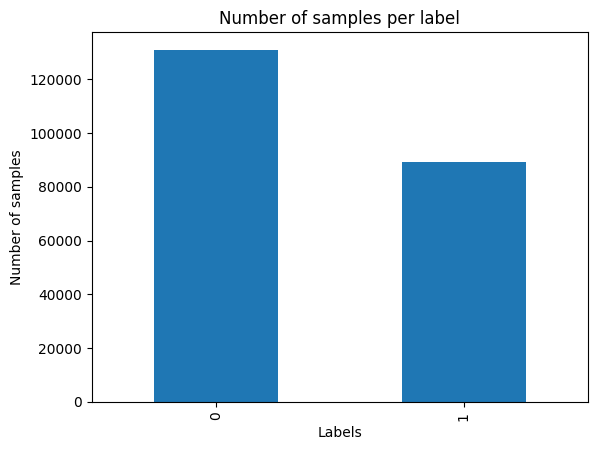

In [3]:
import matplotlib.pyplot as plt
num_samples = len(df['id'])
print(f"There are {num_samples} samples, and the data shape is: {df.shape}\n")

class_counts = df.value_counts(df["label"])
class_counts.plot(kind="bar")
plt.title("Number of samples per label")
plt.xlabel("Labels")
plt.ylabel("Number of samples")
plt.show()

We can see that we're working with about ~200k images with simple binary labels without duplicates or null values.  Clean data so far....

In [4]:
print(f"Number of duplicated values: {len(df[df.duplicated()])}")
print(f"Number of null values: {len(df[df.isnull().any(axis=1)])}")

Number of duplicated values: 0
Number of null values: 0


Image dimensions: 96x96 (Channels: 3)
Image dimensions: 96x96 (Channels: 3)
Image dimensions: 96x96 (Channels: 3)
Image dimensions: 96x96 (Channels: 3)


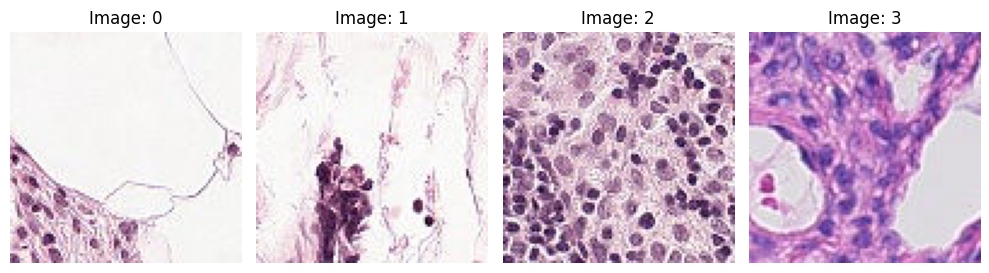

In [5]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def show_image(image_id, dir_path=train_image_path):
    assert len(image_id) > 0
    image_path = f"{dir_path}train/{image_id}.tif"
    
    # Load the image using matplotlib
    image = mpimg.imread(image_path)

    # print(f"Showing {image_path}.  Image Channels: {image.mode}")
    
    # What are the image dimensions
    height, width, channels = image.shape
    print(f"Image dimensions: {width}x{height} (Channels: {channels})")

    return image

num_images = 4
fig, axes = plt.subplots(1, num_images, figsize=(10, 5))  # Adjust figsize as needed

for i in range(num_images):
    image = show_image(df["id"][i])
    axes[i].imshow(image)
    axes[i].axis('off')
    axes[i].set_title(f"Image: {i}")
plt.tight_layout()
plt.show()

And sample images look good so far.  Since these are 96x96x3 (height, width, and 3 channels for RGB), we may need to greyscale or downsample these images for speedy processing, but that will come later in model training and tuning.

# Model Architecture
With image recognition tasks, we could pull an off the shelf solution like ResNet, GoogleNet, or the myriad other trained model as a start, but given this is a class exercise, I will instead propose and train a model from scratch.

Starting with the basic requirements of maintaining spatial data across the model, I will propose training a convolutional neural network.  Similarly, this rules out both simpler linear models for the inability to fit complex data as well as heavier architectures like recurrent neural networks since there is no requirement for processing sequential data.

## Block Architecture

Moreover, keeping in line with the industry standard paradigm of modular blocks, I will start with a basic block/module of 
1. Convolution layer composed of a stack of 64 3x3 filters (16 filters per RGB channel + 16 greyscale)
2. Batch normalization
3. Relu
4. Convolution
5. Batch Normalization
6. Skip Connection (which adds the input weights to output of the second convolution layer)
7. Relu

This architecture mirrors a standard ResNet block. Modifications will be discussed later. 

Overall, my initial architecture will be for a 6 layer deep CNN composed of 3 stages with 2 layers each ([2,2,2]).  

## Channel Processing + Feature Maps
As these images are color images, they natively have 3 channels for RGB (red, green, and blue respectively).  I will use a series of color/channel specific filters to create feature maps for each color as well as an additional filter for greyscale feature maps.  These feature maps will be concatenated for further processing.

I will downsample the images/feature maps using max pooling to preserve the most salient features. Similarly, I will use ResNet defaults of 3x3 filters with a stride of 2 twice within the model to properly downsample to a final 24x24 image output.

## Architecture Details

### Initial Layers
As mentioned above, I will be starting with the ResNet architecture, but making some important modifications to speed up training, narrow the model specifically to task at hand, and hopefully improve architecture

Convolutional Filters: 3x3 vs 7x7 in ResNet.  Smaller filters require more layers to achieve the same receptive field but enable higher-resolution feature maps and offer computational savings.  In addition, the smaller image sizes that we're working with would lose a great deal of information via larger 7x7 filters. 

* 3x3 filters, stride: 1, padding: 1px to preserve initial image size

### Residual Blocks
ResNet uses a two block per stage architecture that I will be reusing here. For my inital approach, I will use two rounds of max pool downsampling in stages 2 and 3, reducing the image/feature maps from 96x96 to 48x48 to 24x24. 

Alongside the rounds of downsampling, it is typical to double the number of feature maps along with downsampling to maintain relatively equal amount of computation between the blocks in the network.  As such,
* Stage 1: 96x96x64 image size, 16 filters per channel to 64 total channels
* Stage 2: 48x48x128 image size, 32 filters/channel, 128 total
* Stage 3: 24x24x256 image size, 64 filters/channel, 256 total

Ultimately, the output of these 3 stages will lead to the final layers

1. A final global average pooling layer for aggregation (24x24x256 -> 1x1x256)
1. A single fully connected layer to reduce the number of parameter, using a single output neuron with a sigmoidal activation and a binary cross entropy loss function.


Earlier state of the art CNNs like AlexNet used a series of fully connected layers involving a ton of neurons, with a corresponding ton of weights/parameters that needed to be trained.  Later architectures like ResNet would yield better results with dramatically fewer parameters, so I will be reusing the same ResNet FC architecture as well.

In [6]:
import torch
import torch.nn as nn

class BasicBlock(nn.Module):
    expansion = 1  # No expansion for basic blocks

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

In [7]:
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=2):
        super(ResNet, self).__init__()
        self.inplanes = 64  # Number of input channels for the first layer

        # Initial convolutional layer
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Residual blocks
        self.layer0 = self._make_layer(block, 64, layers[0], stride=1)   # Stage 1: 2 blocks, 64 channels
        self.layer1 = self._make_layer(block, 128, layers[1], stride=2)  # Stage 2: 2 blocks, 128 channels
        self.layer2 = self._make_layer(block, 256, layers[2], stride=2)  # Stage 3: 2 blocks, 256 channels

        # Global average pooling and fully connected layer
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))  # Adaptive pooling to handle variable input sizes
        self.fc = nn.Linear(256 * block.expansion, num_classes)  # Fully connected layer

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        # Downsample if the number of channels changes or the spatial dimensions change
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        # First block in the layer (may include downsampling)
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion  # Update inplanes for the next block

        # Additional blocks in the layer
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        # Initial layers
        x = self.conv1(x)
        x = self.maxpool(x)

        # Residual blocks
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)

        # Global average pooling and fully connected layer
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.fc(x)

        return x

## A brief aside
This notebook is the product of an academic assignment to meet a specific rubric, but I did want to address some of the "real world" constraints and complications that typical classes don't really address. I.e. data loading, parallelization, and just simply optimizing the efficiency of model training.

Speaking only to the optimal usage of hardware using PyTorch, I found that my inital efforts at training were bottlenecked not by GPU usage, but by the CPU usage, especially in the data transformation/tensorization of the images.  

Long story short, I experimented with increasing the number of CPU based workers to noticable improvement, but still bottlenecked by CPU processes.  The next attempt was to just pre-compute and cache the transformation results, but was quickly checked by the explosively large file size which tanked an entire Kaggle container.    

Finally, I moved towards a number of storage/vector storage solutions with compression like h5py.  After realizing how many of these solutions are bounded by single threads and therefore unable to scale to parallelized cpu workers, I eventually settled on Zarr.  

Using Zarr to compress and store the tensors (and subsequently uncompress for at training time) enabled:
* reduced the total model training time by 30-50%
* relatively full gpu saturation/usage across model training
* provided a series of quick and efficient OOTB compression algorithms which prevented voluminous storage requirements while also yielding near-realtime decompression to fully utilize parallelization upon the GPU.
* enabled _much_ more rapid experimentation by avoiding the re-computation of the same tensors over different models
* and most importantly, reduced the overall energy + water consumption, by full utilization of the hardware rather than wasting GPU cycles idling behind the CPU bottleneck


In [8]:
!pip install zarr
import os
import torch
import zarr
import numpy as np
from torch.utils.data import Dataset
from PIL import Image

class MyDataset(Dataset):
    def __init__(self, dataframe, transform=None, data_dir=train_image_path, cache_file='cached_images2.zarr'):
        self.data = dataframe.iloc[:, :-1].values  # Features (all columns except the last)
        self.labels = dataframe.iloc[:, -1].values  # Labels (last column)
        self.transform = transform
        self.data_dir = data_dir
        self.cache_file = cache_file
        
        # Initialize or open the Zarr store
        self.initialize_cache()
    
    def initialize_cache(self):
        """Initialize or open the Zarr store"""
        # Create or open the Zarr store
        self.store = zarr.DirectoryStore(self.cache_file)
        self.root = zarr.group(store=self.store, overwrite=False)
        
        # Create a group for images if it doesn't exist
        if 'images' not in self.root:
            self.root.create_group('images')
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        image_id = str(self.data[idx][0])
        
        # Try to load from Zarr cache
        if image_id in self.root['images']:
            cached_data = self.root['images'][image_id][:]
            image = torch.from_numpy(cached_data).float()  # Convert to float32 tensor
        else:
            # Load image from disk
            image_path = f"{self.data_dir}train/{image_id}.tif"
            image = Image.open(image_path)
 
            if self.transform:
                image = self.transform(image)
            
            # Cache the transformed image in Zarr
            if isinstance(image, torch.Tensor):
                image_numpy = image.cpu().numpy()  # Convert tensor to NumPy
            else:
                image_numpy = np.array(image)  # Convert PIL image to NumPy
            
            # Store in Zarr
            self.root['images'].create_dataset(
                image_id,
                data=image_numpy,  # Store as NumPy array
                chunks=True,  # Enable chunked storage
                compression='zstd'  # Optional compression
            )
        
        # Load label
        label = self.labels[idx]
        
        return image, label
    
    def clear_cache(self):
        """Clear the entire Zarr store"""
        if os.path.exists(self.cache_file):
            import shutil
            shutil.rmtree(self.cache_file)
        self.initialize_cache()

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.7/210.7 kB 5.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 74.8 MB/s eta 0:00:00:00:0100:01
  Created wheel for asciitree: filename=asciitree-0.3.3-py3-none-any.whl size=5034 sha256=65db287b0ebe84988e2b686179a6a01bb1b64c5dbb1221d2d6d7c69c9cd2f894
  Stored in directory: /root/.cache/pip/wheels/7f/4e/be/1171b40f43b918087657ec57cf3b81fa1a2e027d8755baa184
Successfully built asciitree


In [9]:
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.model_selection import train_test_split

def data_loader(data_dir=train_image_path,
                batch_size=256,
                random_seed=42,
                test_size=0.1,
                shuffle=True,
                test=False,
                num_workers=4):

    train_df, test_df = train_test_split(df, test_size=test_size, random_state=random_seed)

    transform_default = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), # tbd, get real mean and std dev
    ])

    train_dataset = MyDataset(train_df, transform_default)
    test_dataset = MyDataset(test_df, transform_default)

    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, num_workers=num_workers, pin_memory=True)

    test_loader = torch.utils.data.DataLoader(
        test_dataset, batch_size=batch_size,  num_workers=num_workers, pin_memory=True)

    return (train_loader, test_loader)
    
train_loader, test_loader = data_loader(batch_size=256) 

# Sample the dataloader and verify data shape....
for batch_idx, (images, labels) in enumerate(train_loader):
    if batch_idx < 2:
        print(f"Batch {batch_idx + 1}:")
        print("Images shape:", images.shape)  # Should be [batch_size, channels, height, width]
        print("Labels:", labels)
    else:
        break

Batch 1:
Images shape: torch.Size([256, 3, 96, 96])
Labels: tensor([1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0,
        1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1,
        0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
        1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0,
        1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1,
        0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0,
        1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1,
        0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0,
        1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0])
Batch 2:
Images shape: torch.Size([256, 3, 96, 96])
Labels: tensor([0, 1, 1, 1, 0, 

In [10]:
# Ensure GPUs are working as intended...
import torch
print("Is CUDA available?", torch.cuda.is_available())
if torch.cuda.is_available():
    print("CUDA device count:", torch.cuda.device_count())
    print("Current CUDA device:", torch.cuda.current_device())
    print("CUDA device name:", torch.cuda.get_device_name(0))

Is CUDA available? True
CUDA device count: 1
Current CUDA device: 0
CUDA device name: Tesla P100-PCIE-16GB


# Initial Training Strategy
In contrast with the section above, most of these strategies are pretty universal/common.

* Number of epochs (rounds of training): 10
* Batch size: 64
* Optimizer: SGD with momentum  (ADAM is also a reasonable choice, as both enable better convergence towards a global minima over local minima with plain SGD or vanilla batch gradient descent, but starting with SGD + momentum to experiment with hyperparameters)
* Learning rate: 1e-3
* Weight decay: 1e-3, given we're using momentum based optimizers, we want a way of slowing down the rate of gradient descent as we reach later rounds of optimization to prevent overshooting the global minima
* Regularization: None initially, but I'll consider L2 regularization pending results of overfitting


In [11]:
import gc
import time 
num_classes = 2
num_epochs = 12 # formerly 20, but plateaued around 10-15 epochs
batch_size = 64
learning_rate = 1e-3

train_loader, test_loader = data_loader(batch_size=batch_size) 

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("GPU Memory Allocated:", torch.cuda.memory_allocated(device) / 1e6, "MB")
print("GPU Memory Cached:", torch.cuda.memory_reserved(device) / 1e6, "MB")

model = ResNet(BasicBlock, [2,2,2]).to(device)

#Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay = 0.001)

#Train the model
total_step = len(train_loader)
start_time = time.time()

for epoch in range(num_epochs):
  for i, (images, labels) in enumerate(train_loader):
    # if i % 200 == 0:
    #     print(f"#{epoch} - GPU Memory Allocated:", torch.cuda.memory_allocated(device) / 1e6, "MB")
    #     print(f"#{epoch} - GPU Memory Cached:", torch.cuda.memory_reserved(device) / 1e6, "MB")

    #Move tensors to the configured device
    images = images.to(device)
    labels = labels.to(device)

    #Forward pass
    outputs = model(images)
    loss = criterion(outputs, labels)

    #Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    del outputs
    if i % 10:
        del images, labels
        torch.cuda.empty_cache()
        # gc.collect()
  print(f"--Pending model training time: {time.time() - start_time:.2f} seconds")

  print ('Epoch [{}/{}], Loss: {:.4f}' 
               .format(epoch+1, num_epochs, loss.item()))
print(f"Final model training time: {time.time() - start_time:.2f} seconds")
  

#Validation
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        del images, labels, outputs

    print('Accuracy of the network on the {} test images: {} %'.format(5000, 100 * correct / total))
# T4x2 [2,2,2] (20 epochs?): Final model training time: 2014.06 seconds, test acc: 81%
# T4x2 [3,4,6,3] (12 epochs): Final model training time: 1566.06 seconds, test acc: 81%
# (submission 6) P100 [2,2,2] (12 epochs, 0.001 LR): Final model training time: 1278.97 seconds
# (submission 7) "   " (12 epochs, 0.01 LR, 64 batch size): 1198.08 seconds: test acc 86%
# (submission 9) " " (12 epochs, 1e-3 LR, 64 batch size, 3x3 filters): 1892.06 seconds: 81%

GPU Memory Allocated: 0.0 MB
GPU Memory Cached: 0.0 MB
--Pending model training time: 615.51 seconds
Epoch [1/12], Loss: 0.0338
--Pending model training time: 805.51 seconds
Epoch [2/12], Loss: 0.0298
--Pending model training time: 955.31 seconds
Epoch [3/12], Loss: 0.0223
--Pending model training time: 1069.88 seconds
Epoch [4/12], Loss: 0.0200
--Pending model training time: 1183.81 seconds
Epoch [5/12], Loss: 0.0100
--Pending model training time: 1296.38 seconds
Epoch [6/12], Loss: 0.0147
--Pending model training time: 1409.03 seconds
Epoch [7/12], Loss: 0.0038
--Pending model training time: 1519.94 seconds
Epoch [8/12], Loss: 0.0004
--Pending model training time: 1632.24 seconds
Epoch [9/12], Loss: 0.0004
--Pending model training time: 1745.20 seconds
Epoch [10/12], Loss: 0.0000
--Pending model training time: 1858.87 seconds
Epoch [11/12], Loss: 0.0000
--Pending model training time: 1971.55 seconds
Epoch [12/12], Loss: 0.0000
Final model training time: 1971.55 seconds
Accuracy of th

# Model Evaluation
I'll be using accuracy as the primary metric to evaluate the model's efficacy, as its the only metric returned from Kaggle contest submissions.  Similarly, while I might achieve a high validation accuracy with some models, the inability for the models to generalize to the test dataset just represents overfitting to the training data. 

As such, the most accurate model was surprisingly the [2,2,2] architecture trained over 12 epochs with an ADAM optimizer 1e-2 learning rate, and a 64 item batch size.  

## Exploring the less optimal variants

### Alternate Architectures
Using the offical ResNet archtecture of [3,4,6,3] resulted in a middling accuracy of 81%, but required much more compute. Other architectures of [2,2,2,2] and other experimentations resulted in unremarkable performance.

### Tuning Learning Rate and momentum
Similarly, using a greater learning rate of 1e-1 performed worse across the validation and test dataset as well as increased momentum values.  A lower learning rate of 1e-4 was decent, but required more epochs + compute for convergence as well as a largely unchanged final perfomance.

### Kernel size + receptive field
Starting with the default ResNet kernel size of 7, stride of 2, with 3px padding yielded strong results, but moving to an equivalent stack of kernel size 3, stride 1, 1px padding improved tes accuracy by ~3%

### Tuning training epochs
Increasing epochs or total iterations across the training set yielded plateauing performance on validation and test datasets, as my initial guess of 20 epochs was less performant than early stopping/fewer epochs wherein I eventually settled on 12 total epochs.

### Misc.
I experimented with different hardware configurations as allowed by the free tier of Kaggle, which thankfully didn't meaningfully modify model accuracy, but did substantially change the training time.  As a future improvement, updating the training code to fully utilize the dual T4 configuration would be ideal.

In [12]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from PIL import Image
import pandas as pd
import os

# Define a custom dataset for the test images
class TestDataset(torch.utils.data.Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.image_names = os.listdir(image_dir) 
        self.transform = transform

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, self.image_names[idx])
        image = Image.open(image_path)
        if self.transform:
            image = self.transform(image)
        return image, self.image_names[idx]  

# Define transformations for the test data
transform_test = transforms.Compose([
    transforms.Resize((96, 96)),  # Resize to match training size
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # Normalize
])

# Create the test dataset and DataLoader
test_dir = '/kaggle/input/histopathologic-cancer-detection/test'
test_dataset = TestDataset(test_dir, transform=transform_test)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)

# Generate predictions
predictions = []
filenames = []
with torch.no_grad():  # Disable gradient computation
    for images, names in test_loader:
        images = images.to('cuda')  # Move images to GPU
        outputs = model(images)  # Forward pass
        _, preds = torch.max(outputs, 1)  # Get predicted class indices
        predictions.extend(preds.cpu().numpy())  # Move predictions to CPU and convert to numpy
        filenames.extend(names)  # Save filenames

filenames = [name[:-4] for name in filenames]

# Create a submission DataFrame
submission_df = pd.DataFrame({
    'id': filenames,
    'label': predictions
})

submission_filename = 'submission-adam-1e2.csv'
# Save the submission file
submission_df.to_csv(submission_filename, index=False)
print(f"Submission file saved as '{submission_filename}'")

Submission file saved as 'submission-adam-1e2.csv'


# Conclusion
In conclusion, using the ResNet architecture to identify metastatic cancer tissue has been reasonably accurate, at a maximum accuracy of ~88%.  While this is far below the best results of ~98% accuracy, this naive exercise was illuminative to the complexities of deep neural networks/CNNs.  

Unsurprisingly, reducing the learning rate to 1e-3 with an ADAM optimizer yielded the strongest improvement in the model, while architectural or other optimizer focused modifications yielded mixed results.

Future explorations would include implementations of more state of the art architectures like EfficientNet in order to both improve accuracy, but also achieve much smaller and efficient models.  Similarly, employing model distillation of larger models like ResNet-152 or GoogleNet could yield improved results, or at least substantially reduce the compute needed for comparable results.

# References
1. [ResNet Paper](https://arxiv.org/abs/1512.03385)
2. [Stanford](https://www.youtube.com/watch?v=vT1JzLTH4G4&list=PL3FW7Lu3i5JvHM8ljYj-zLfQRF3EO8sYv) and [MIT Deep Learning](https://www.youtube.com/watch?v=ErnWZxJovaM&list=PLtBw6njQRU-rwp5__7C0oIVt26ZgjG9NI) courses

# Resources
1. [How to write ResNet from scratch](https://www.digitalocean.com/community/tutorials/writing-resnet-from-scratch-in-pytorch)
2. [GPU Saturation using Zarr](https://earthmover.io/blog/cloud-native-dataloader/) 